In [311]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
import pandas as pd
import os

In [312]:
train_path = 'mc_data/train/'
test_path = 'mc_data/test/'

In [313]:
def one_hot(img):
    # img is the file name of a configuration
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,float(T)
def data_with_label(data_path,*args):
    data = []
    if args: # The args are a list if directories in the data path that separate the classes/categories
        for category in args:
            for i in tqdm(os.listdir(data_path + category)):
                path = os.path.join(data_path, category,i)
                img = np.load(path)
                data.append([img.astype(dtype='float32'), one_hot(i)])
        shuffle(data)
        return data

In [314]:
train_set=data_with_label(train_path,'low','high')
test_set=data_with_label(test_path,'low','high')

train_configs = [i[0] for i in train_set]
train_labels = [i[1][0] for i in train_set]
train_temps = [i[1][1] for i in train_set]

test_configs = [i[0] for i in test_set]
test_labels = [i[1][0] for i in test_set]
test_temps = [i[1][1] for i in test_set]

100%|██████████| 200/200 [00:00<00:00, 2497.07it/s]


In [315]:
train_data = TensorDataset(torch.Tensor(train_configs), torch.Tensor(train_labels))
test_data = TensorDataset(torch.Tensor(test_configs), torch.Tensor(test_labels))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [316]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(900, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2),
    torch.nn.Softmax(dim=1)
)

In [317]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.BCELoss()

num_epochs = 20
for epoch in range(num_epochs):
    loss_ = 0
    for x, labels in train_loader:

        # Forward Pass
        output = model(x)
        # Loss at each oteration by comparing to target(label)
        loss = criterion(output, labels)

        # Backpropogating gradient of loss
        optimizer.zero_grad()
        loss.backward()

        # Updating parameters(weights and bias)
        optimizer.step()

        loss_ += loss.item()
    print("Epoch{}, Training loss:{}".format(epoch, loss_ / len(train_loader)))

Epoch0, Training loss:0.5452020580951984
Epoch1, Training loss:0.39650458785203785
Epoch2, Training loss:0.3259184268804697
Epoch3, Training loss:0.2790455932800586
Epoch4, Training loss:0.2406641199038579
Epoch5, Training loss:0.21303675610285538
Epoch6, Training loss:0.1905617771240381
Epoch7, Training loss:0.17410369561268732
Epoch8, Training loss:0.15713727244964013
Epoch9, Training loss:0.1421415645342607
Epoch10, Training loss:0.13150413964803404
Epoch11, Training loss:0.12268550980549592
Epoch12, Training loss:0.11115220475655335
Epoch13, Training loss:0.1042629314156679
Epoch14, Training loss:0.09669505174343403
Epoch15, Training loss:0.09111455197517689
Epoch16, Training loss:0.08336805666868503
Epoch17, Training loss:0.07981289980503228
Epoch18, Training loss:0.07406612313710727
Epoch19, Training loss:0.0697322075183575


In [318]:
with torch.no_grad():
    correct = 0
    total = len(test_loader.dataset)
    low_pred = []
    high_pred = []
    for x, labels in test_loader:
        out = model(x)
        predicted = torch.argmax(out, dim=1)
        labels = torch.argmax(labels, dim=1)
        
        for i in range(len(predicted)):
            if predicted[i] == labels[i]:
                correct+=1

            low_pred.append(float(out[i][0]))
            high_pred.append(float(out[i][1]))
        # print(labels)
        
    print('Test accuracy: {} %'.format(100 * correct / total))

Test accuracy: 98.75 %


Text(0, 0.5, 'Output from neurons')

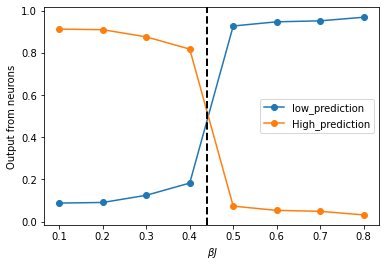

In [319]:
df1 = pd.DataFrame({'low_prediction':low_pred,'High_prediction':high_pred, 'Temp':test_temps})
df1.head()

df2=df1.groupby('Temp').mean()
df2.head()

df2.plot(marker='o')
plt.axvline(1/2.27,c='black', linestyle ='--',lw=2)
plt.xlabel(r" $\beta J$")
plt.ylabel("Output from neurons")